# CNN for AED with Keras/TensorFlow

Date: November 11, 2018 and February 27, 2019

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music
- Silence

## Preparing data set for CNN

In [11]:
DATASET_FOLDER = '../dataset/data_music'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate()
shape = ds.shape
class_labels = ds.class_labels

In [12]:
shape

(64, 40)

### CNN model

In [13]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

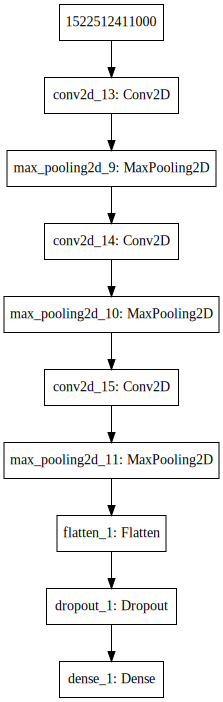

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [16]:
EPOCHS = 100
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 384 samples, validate on 216 samples
Epoch 1/100
384/384 [==============================] - 4s 9ms/step - loss: 1.7896 - acc: 0.1979 - val_loss: 1.7310 - val_acc: 0.2361
Epoch 2/100
384/384 [==============================] - 3s 7ms/step - loss: 1.6997 - acc: 0.2604 - val_loss: 1.6445 - val_acc: 0.3657
Epoch 3/100
384/384 [==============================] - 2s 6ms/step - loss: 1.5976 - acc: 0.3854 - val_loss: 1.5422 - val_acc: 0.4213
Epoch 4/100
384/384 [==============================] - 3s 8ms/step - loss: 1.5214 - acc: 0.4453 - val_loss: 1.4137 - val_acc: 0.6065
Epoch 5/100
384/384 [==============================] - 3s 7ms/step - loss: 1.3460 - acc: 0.5286 - val_loss: 1.2546 - val_acc: 0.6296
Epoch 6/100
384/384 [==============================] - 3s 7ms/step - loss: 1.2521 - acc: 0.5469 - val_loss: 1.1165 - val_acc: 0.6898
Epoch 7/100
384/384 [==============================] - 2s 5ms/step - loss: 1.0857 - acc: 0.6276 - val_loss: 0.9805 - val_acc: 0.7315
Epoch 8/100
384/384 [==

Epoch 62/100
384/384 [==============================] - 2s 6ms/step - loss: 0.1316 - acc: 0.9557 - val_loss: 0.3011 - val_acc: 0.8750
Epoch 63/100
384/384 [==============================] - 3s 7ms/step - loss: 0.0917 - acc: 0.9766 - val_loss: 0.3187 - val_acc: 0.8935
Epoch 64/100
384/384 [==============================] - 2s 6ms/step - loss: 0.1202 - acc: 0.9609 - val_loss: 0.2901 - val_acc: 0.8981
Epoch 65/100
384/384 [==============================] - 3s 7ms/step - loss: 0.1083 - acc: 0.9557 - val_loss: 0.2740 - val_acc: 0.9074
Epoch 66/100
384/384 [==============================] - 2s 6ms/step - loss: 0.1295 - acc: 0.9583 - val_loss: 0.3068 - val_acc: 0.8935
Epoch 67/100
384/384 [==============================] - 3s 7ms/step - loss: 0.0895 - acc: 0.9766 - val_loss: 0.2862 - val_acc: 0.9028
Epoch 68/100
384/384 [==============================] - 3s 7ms/step - loss: 0.0760 - acc: 0.9818 - val_loss: 0.2941 - val_acc: 0.8981
Epoch 69/100
384/384 [==============================] - 3s 7ms

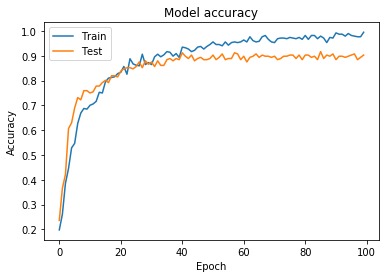

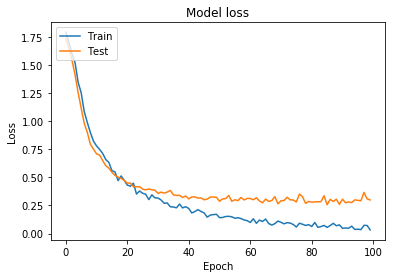

In [17]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [18]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [19]:
del model
model = models.load_model(filename)

## Confirmation

In [20]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(384, 64, 40, 1)

In [21]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [22]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [23]:
class_labels

['piano',
 'classical_guitar',
 'framenco_guitar',
 'blues_harp',
 'tin_whistle',
 'silence']

In [24]:
(activations[-1][:10]*100).astype(int)

array([[  0,   0,   0,   0,  99,   0],
       [  0,   0,  31,  68,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [ 99,   0,   0,   0,   0,   0],
       [  0,   0,   0,  99,   0,   0],
       [  0,   0,   0,   0,   0,  99],
       [  0,   0,   0,   0,  99,   0],
       [ 24,  73,   0,   1,   0,   0],
       [  0,   0,   0,   0, 100,   0],
       [  0,   0,   0,  99,   0,   0]])

In [25]:
test_labels[:10].astype(int)

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0]])

In [26]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'silence'

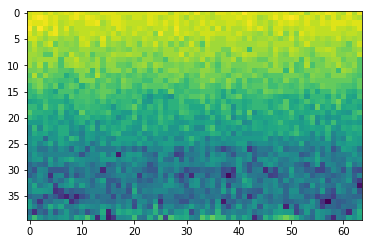

In [27]:
image_number = 29

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

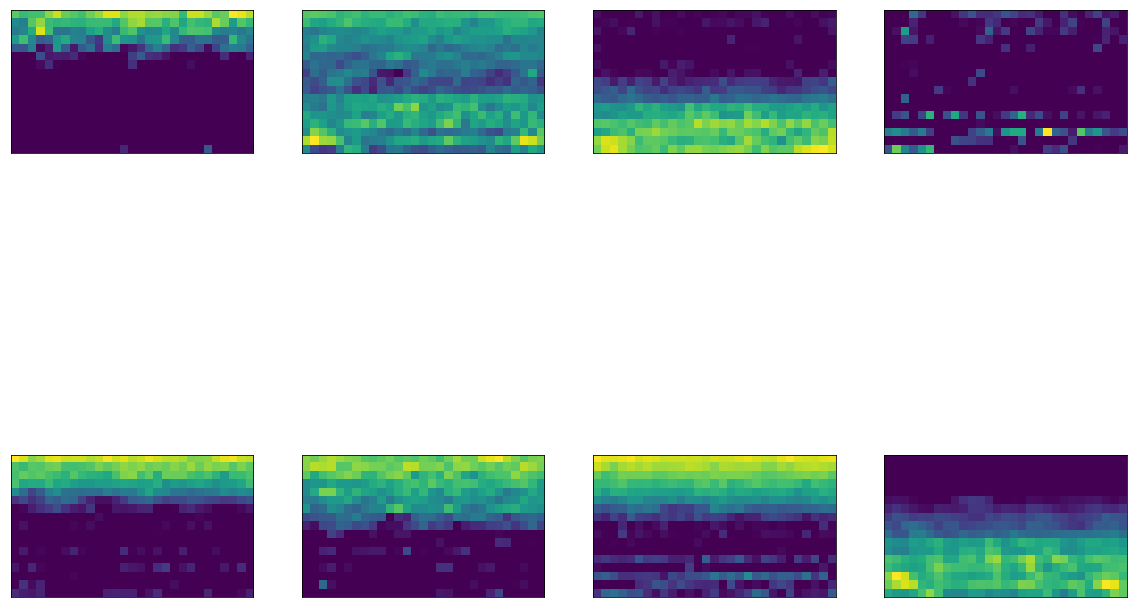

In [28]:
plot_layer(activations, image_number, 2)

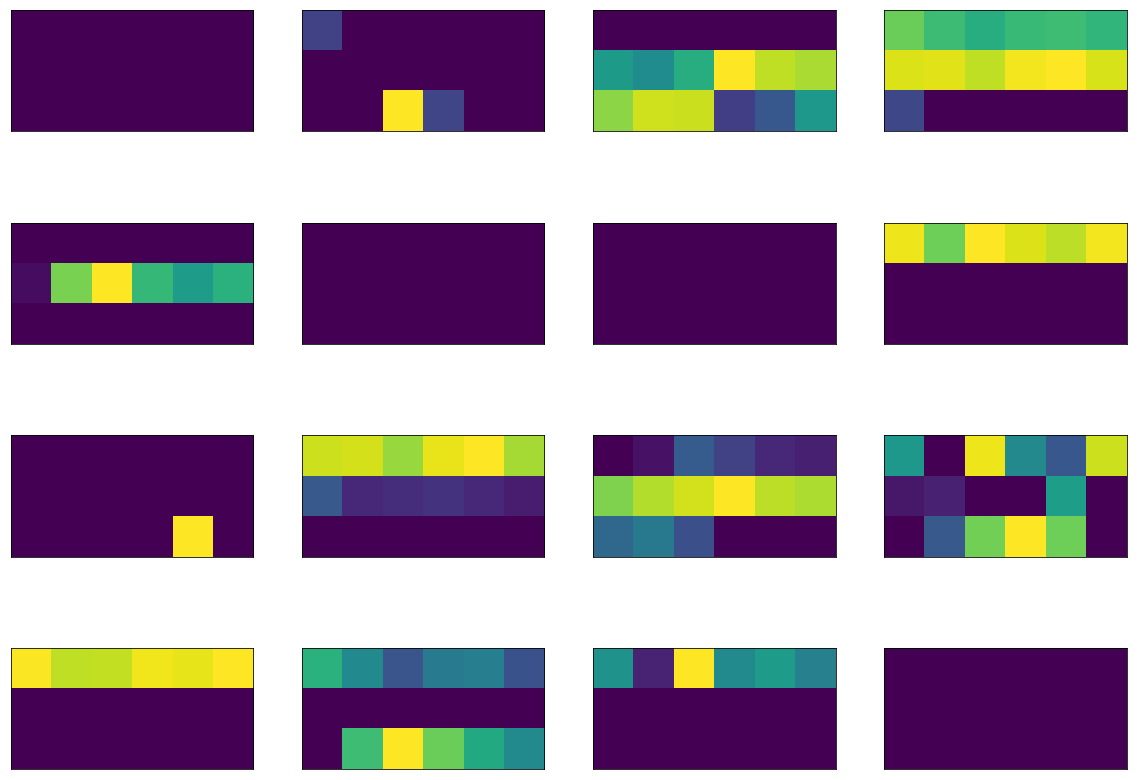

In [29]:
plot_layer(activations, image_number, 5)